In [15]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision 
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import RandomErasing

import matplotlib.pyplot as plt

In [16]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

In [17]:
#get data
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

#get current directory
base_dir = os.getcwd()

#go back one directory
base_dir = os.path.dirname(base_dir) 

# add crop to the directory
base_dir = os.path.join(base_dir, 'crop')

dataset = ImageFolder(root=base_dir)

# get training, validation, and testing data
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Apply transformations only to the training dataset
train_dataset.dataset.transform = transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=8)



In [39]:
image, label = train_dataset[0]
print(image.size(), label)

# print random image from the testing set
image, label = test_dataset[0]
image = image.permute(1, 2, 0)
plt.imshow(image)

torch.Size([3, 224, 224]) 55


In [19]:
# these are the classes for the aircraft
class_names = ["A-10", "A-400M", "AG-600", "AH-64", "AV-8B", "An-124", "An-22", "An-225", "An-72", "B-1", "B-2", "B-21", "B-52", "Be-200", "C-130", "C-17", "C-2", "C-390", "C-5", "CH-47", "CL-415", "E-2", "E-7", "EF-2000", "F-117", "F-14", "F-15", "F-16", "F-22", "F-35", "F-4", "F/A-18", "H-6", "J-10", "J-20", "JAS-39", "JF-17", "JH-7", "KC-135", "KF-21", "KJ-600", "Ka-27", "Ka-52", "MQ-9", "Mi-24", "Mi-26", "Mi-28", "Mig-29", "Mig-31", "Mirage2000", "P-3", "RQ-4", "Rafale", "SR-71", "Su-24", "Su-25", "Su-34", "Su-57", "TB-001", "TB-2", "Tornado", "Tu-160", "Tu-22M", "Tu-95", "U-2", "UH-60", "US-2", "V-22", "Vulcan", "WZ-7", "XB-70", "Y-20", "YF-23", "Z-19"]

In [20]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b3')
        self.bn = nn.BatchNorm1d(1000)  # Add batch normalization
        self.dropout = nn.Dropout(0.5)  # Add dropout layer with rate 0.5
        self.fc = nn.Linear(1000, 74)  # Change the output features to 74
        

    def forward(self, x):
        x = self.efficientnet(x)
        x = self.bn(x)  # Apply batch normalization
        x = self.dropout(x)  # Apply dropout
        x = self.fc(x)
        return x

In [21]:

net = NeuralNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0001, weight_decay=1e-5)

Loaded pretrained weights for efficientnet-b3


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Initialize lists to store the loss values
loss_values = []
val_loss_values = []

for epoch in range(2):
    print(f'Training epoch {epoch + 1}')
    running_loss = 0.0
    net.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f'Training Loss: {epoch_loss:.4f}')
    
    # Validation loop
    net.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = loss_fn(outputs, labels)

            running_val_loss += loss.item()
        
    epoch_val_loss = running_val_loss / len(val_loader)
    val_loss_values.append(epoch_val_loss)
    print(f'Validation Loss: {epoch_val_loss:.4f}')

Training epoch 1
Training Loss: 3.3544
Validation Loss: 1.9917
Training epoch 2
Training Loss: 1.7010
Validation Loss: 1.1284


In [23]:
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

training_accuracy = correct / total
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

Training Accuracy: 76.93%


In [24]:
# Calculate the test accuracy

correct = 0
total = 0

net.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accruacy = correct / total
print(f'Test Accuracy: {accruacy * 100:.2f}%')

Test Accuracy: 69.62%


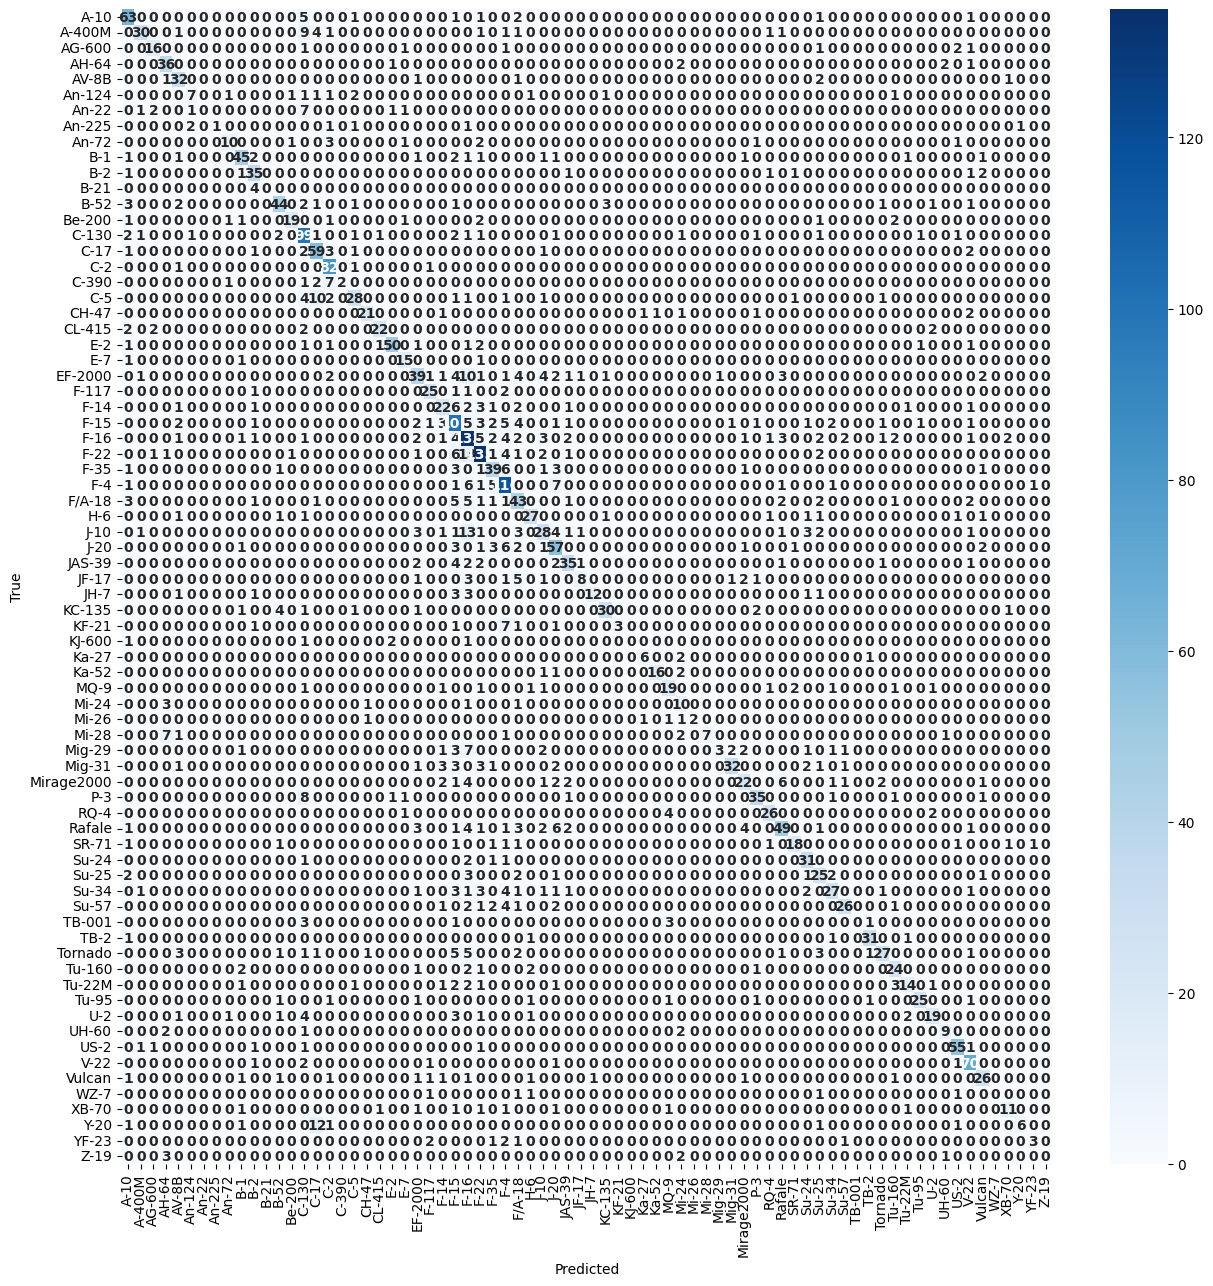

Test Accuracy: 69.46423041189223%


In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test Loop with Confusion Matrix
net.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10, "weight": "bold"})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate and print test accuracy
correct = sum([1 for i, j in zip(all_labels, all_preds) if i == j])
total = len(all_labels)
print(f"Test Accuracy: {100 * correct / total}%")

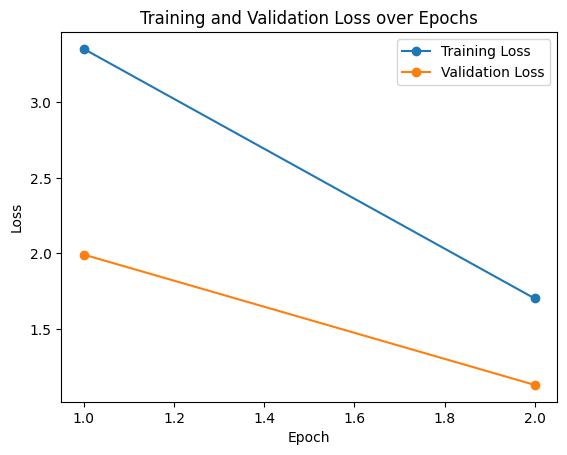

In [26]:
# Plot Loss
epochs = range(1, len(loss_values) + 1)  # Adjust the range based on the length of loss_values

# Ensure both lists have the same length
if len(loss_values) > len(val_loss_values):
	val_loss_values.extend([None] * (len(loss_values) - len(val_loss_values)))
elif len(val_loss_values) > len(loss_values):
	loss_values.extend([None] * (len(val_loss_values) - len(loss_values)))

plt.plot(epochs, loss_values, 'o-', label='Training Loss')
plt.plot(epochs, val_loss_values, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


In [27]:
# save the model
torch.save(net.state_dict(), 'model.pth')